In [33]:
# Standard libaraies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

# sklearn libraries
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve,roc_auc_score,f1_score,recall_score,precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline



# Core packages for text processing.
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# tensorflow and keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
# transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertModel
import torch.nn as nn
import torch
#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:992)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


In [34]:
# Importing the dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(train_df.shape, test_df.shape)

(7613, 5) (3263, 4)


In [35]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [36]:
# Filling in missing values in keyword and location columns
for df in [train_df, test_df]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')
train_df.head()

,id,keyword,location,text,target
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1


In [37]:
# Extract unique values count
unique_keyword_train = train_df["keyword"].nunique()
unique_keyword_test = test_df["keyword"].nunique()
unique_location_train = train_df["location"].nunique()
unique_location_test = test_df["location"].nunique()

# Formatting the printed information
print("Unique Values Count:")
print("---------------------")
print("Keyword:")
print("   Training: {}".format(unique_keyword_train))
print("   Test:     {}".format(unique_keyword_test))
print("\nLocation:")
print("   Training: {}".format(unique_location_train))
print("   Test:     {}".format(unique_location_test))


Unique Values Count:
---------------------
Keyword:
   Training: 222
   Test:     222

Location:
   Training: 3342
   Test:     1603


In [38]:
# Text preprocessing
def preprocess_text(text):
    # Remove URL
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'', text)
    
    # Remove Emoji
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove HTML
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    text = re.sub(html, '', text)
    
    # Remove Punctuation
    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)
    
    # Convert to Lowercase
    text = text.lower()
    
    # Remove Stopwords
    stop = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop])

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])
    
    return text


In [39]:
# Apply Preprocessing
train_df['text_clean'] = train_df['text'].apply(preprocess_text)
test_df['text_clean'] = test_df['text'].apply(preprocess_text)
train_df.head()

,id,keyword,location,text,target,text_clean
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


### Basic EDA

In [40]:
# Tokenize the texts
tokens = [word for text in train_df["text_clean"] for word in text.split()]

# Count unique tokens
unique_words = set(tokens)
number_of_unique_words = len(unique_words)

print(f"Total number of unique words: {number_of_unique_words}")


Total number of unique words: 16646


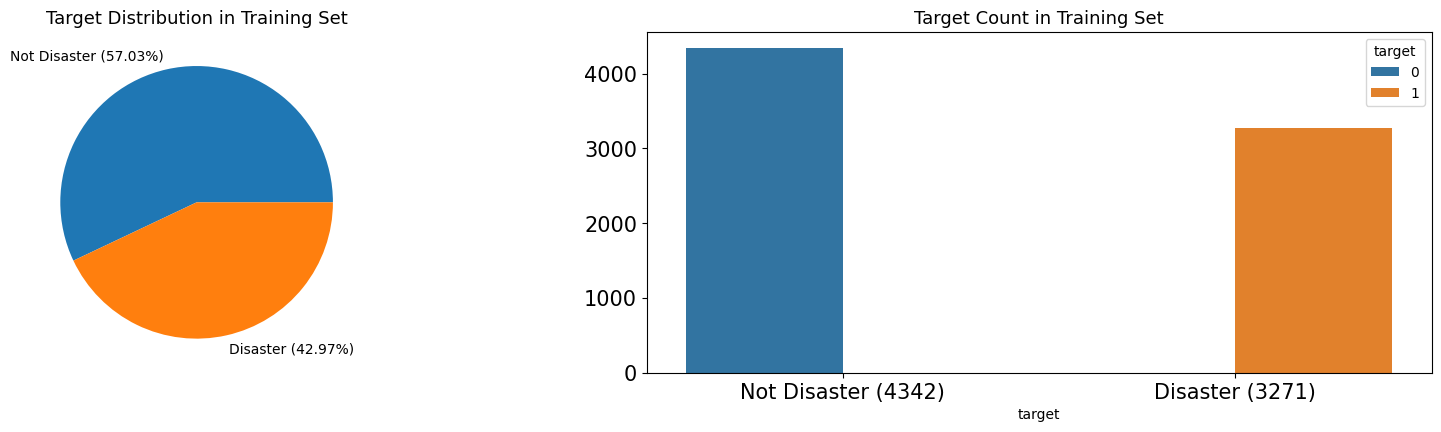

In [41]:
# Calculating the counts and percentages of each target category
count_0 = train_df[train_df['target'] == 0].shape[0]
count_1 = train_df[train_df['target'] == 1].shape[0]
percent_0 = (count_0 / (count_0 + count_1)) * 100
percent_1 = (count_1 / (count_0 + count_1)) * 100

# Creating the subplots
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

# Plotting the pie chart for target distribution
train_df.groupby('target').count()['id'].plot(
    kind='pie', 
    ax=axes[0], 
    labels=[f'Not Disaster ({percent_0:.2f}%)', f'Disaster ({percent_1:.2f}%)']
)
# Plotting the countplot for target count
sns.countplot(x=train_df['target'], hue=train_df['target'], ax=axes[1])

# Setting labels and titles
axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels([f'Not Disaster ({count_0})', f'Disaster ({count_1})'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

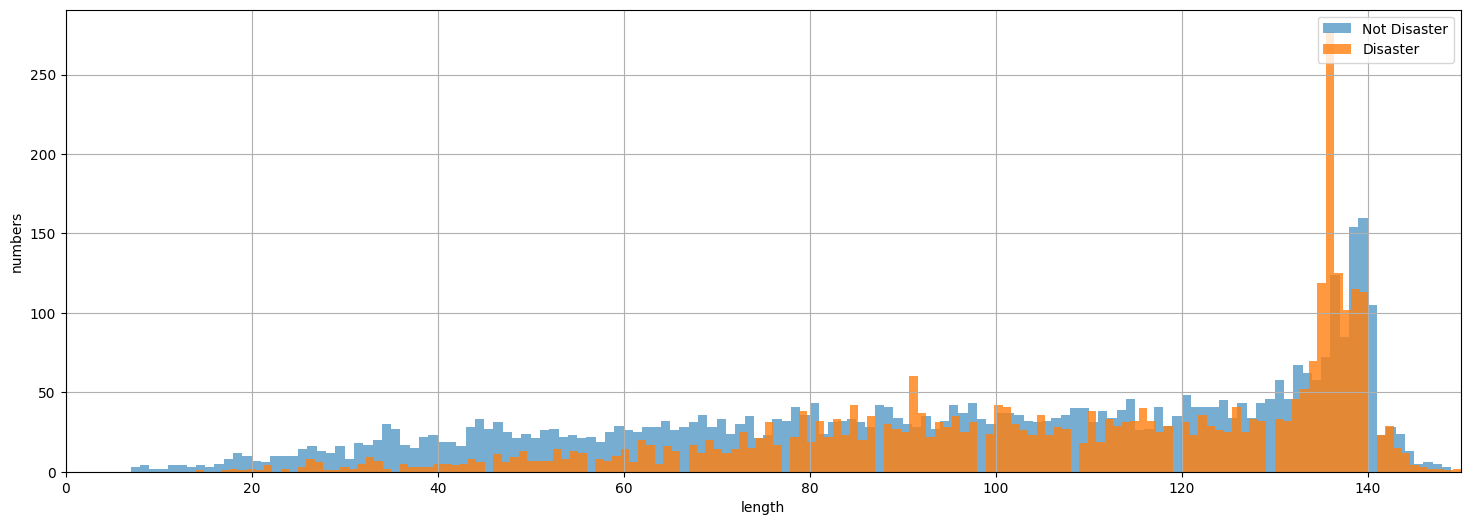

In [42]:
# Histogram of tweet's lengths
def length(text):    
    return len(text)
train_df['length'] = train_df['text'].apply(length)
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(train_df[train_df['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Not Disaster')
plt.hist(train_df[train_df['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Disaster')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

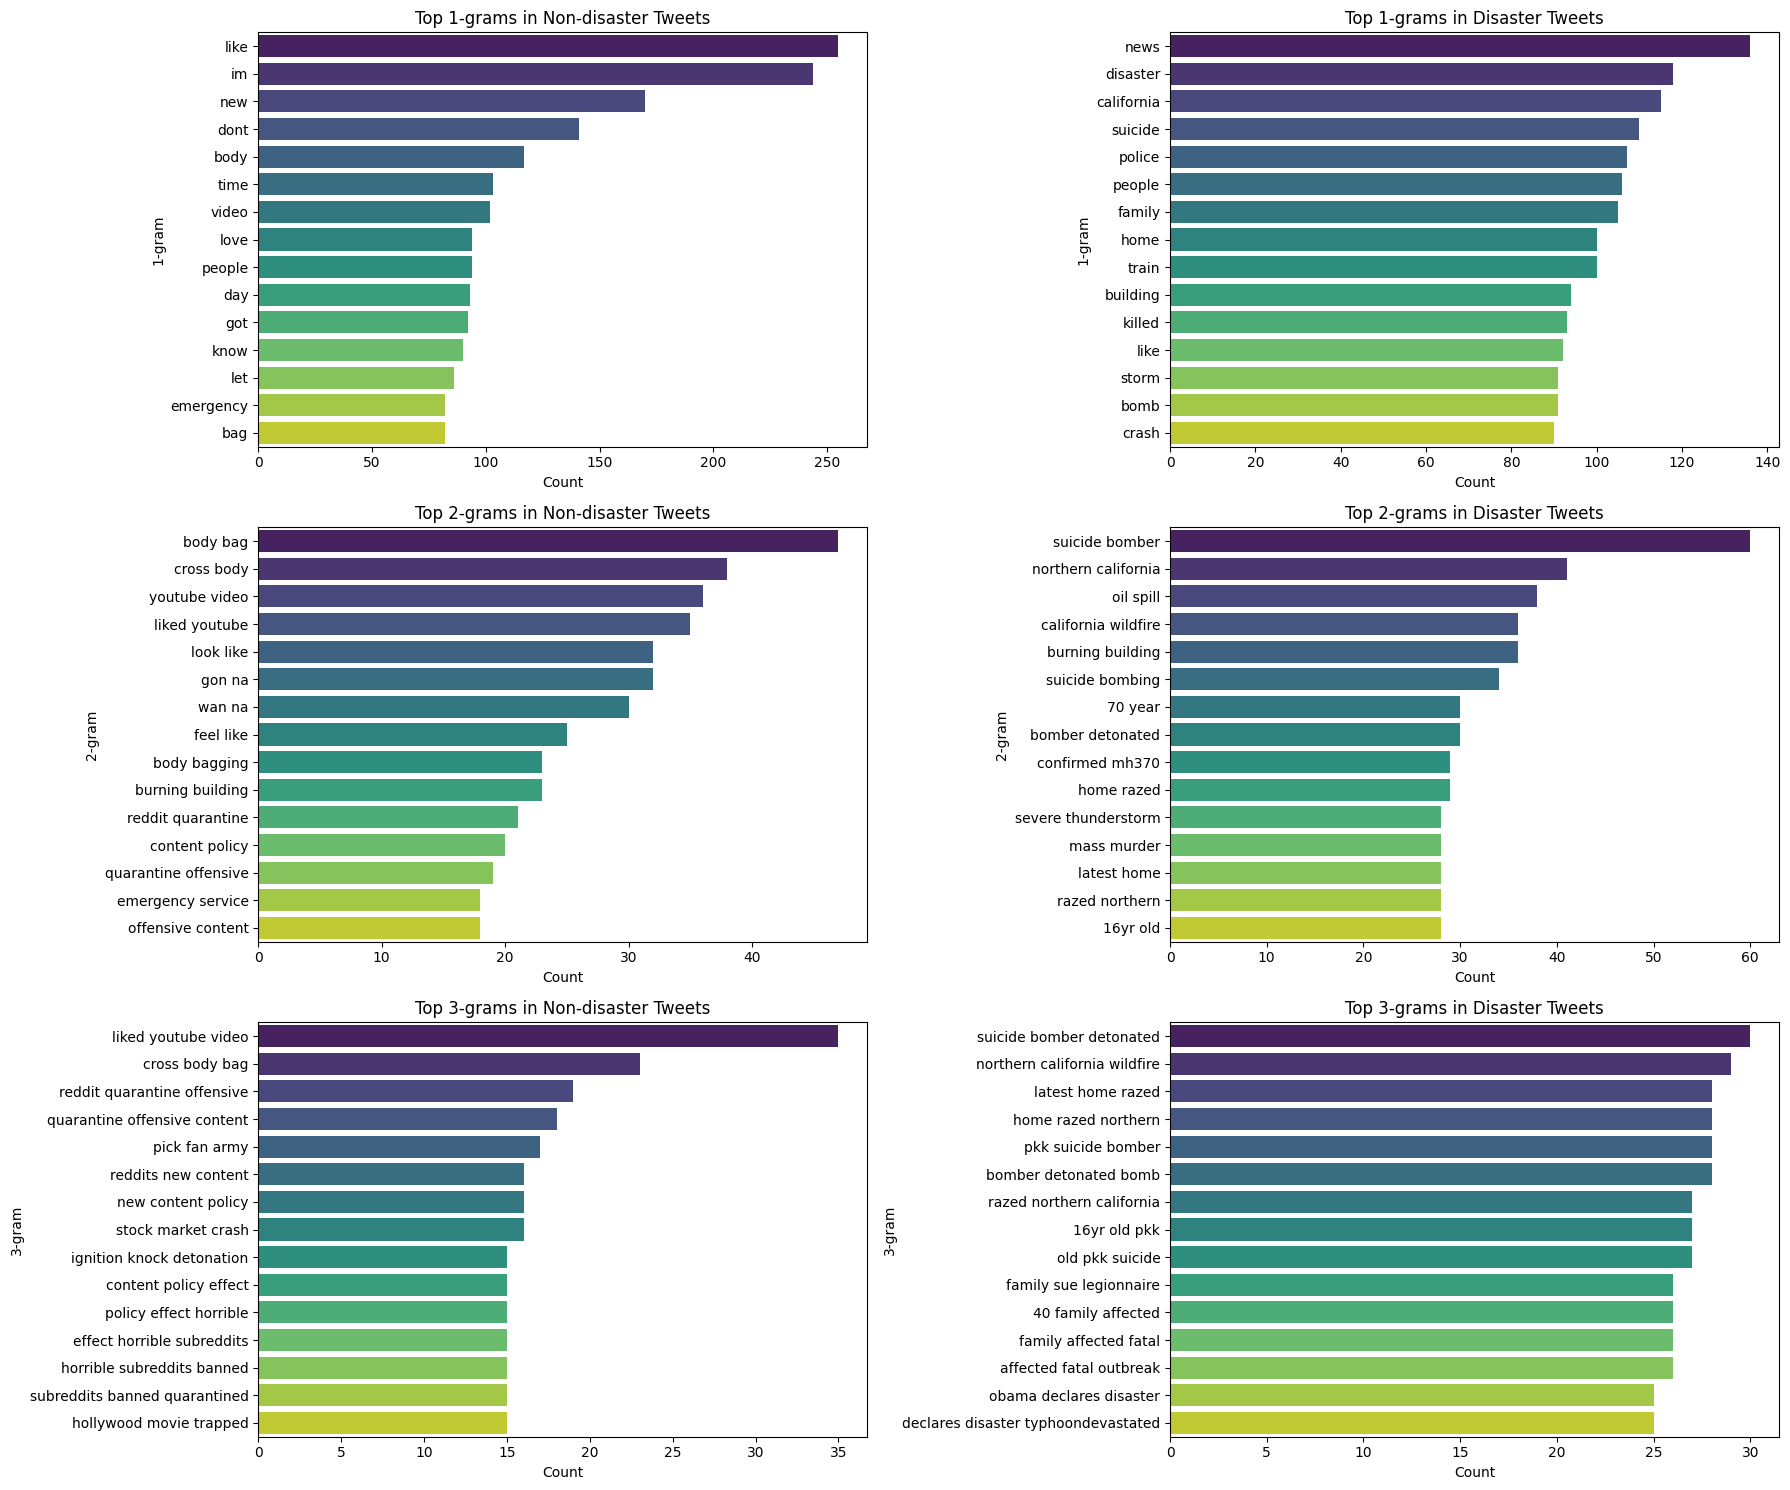

In [43]:
# N gram plots of disaster vs non disaster twets
# Define a function to get top n-grams
def get_top_ngrams(corpus, n, limit):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:limit]

# Separate data into disaster and non-disaster
non_disaster_texts = train_df[train_df['target']==0]['text_clean']
disaster_texts = train_df[train_df['target']==1]['text_clean']

# Get top bi-grams for both categories
top_nondisaster_bigrams = get_top_ngrams(non_disaster_texts, 2, 15)
top_disaster_bigrams = get_top_ngrams(disaster_texts, 2, 15)

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
# Iterate through n-grams
for i, ngram in enumerate([1, 2, 3]):
    # Get top n-grams for both categories
    top_nondisaster_ngrams = get_top_ngrams(non_disaster_texts, ngram, 15)
    top_disaster_ngrams = get_top_ngrams(disaster_texts, ngram, 15)
    
    # Plot non-disaster n-grams
    sns.barplot(x=[count for ngram, count in top_nondisaster_ngrams],
                y=[ngram for ngram, count in top_nondisaster_ngrams],
                ax=axes[i, 0], palette='viridis')

    # Plot disaster n-grams
    sns.barplot(x=[count for ngram, count in top_disaster_ngrams],
                y=[ngram for ngram, count in top_disaster_ngrams],
                ax=axes[i, 1], palette='viridis')

    # Setup plot labels and titles
    axes[i, 0].set_title(f'Top {ngram}-grams in Non-disaster Tweets')
    axes[i, 0].set_xlabel('Count')
    axes[i, 0].set_ylabel(f'{ngram}-gram')
    axes[i, 1].set_title(f'Top {ngram}-grams in Disaster Tweets')
    axes[i, 1].set_xlabel('Count')
    axes[i, 1].set_ylabel(f'{ngram}-gram')

plt.tight_layout()
plt.show()

### Topics using TF-IDF vectors

In [44]:
# Generating a lists for tf-idf calulation to be used for topic generation in the latter paert
lis = [
    train_df[train_df['target'] == 0]['text_clean'],
    train_df[train_df['target'] == 1]['text_clean']
]

In [45]:
# Compute the TF-IDF matrix for a given text
def compute_tfidf(text, max_features=5000, max_df=0.90, min_df=25):
    tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=max_features, use_idf=True)
    tfidf = tfidf_vectorizer.fit_transform(text)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    return tfidf, tfidf_feature_names
# to perform NMF topic modeling
def nmf_topic_modeling(tfidf_matrix, n_components=10, random_state=0, init='nndsvd'):
    nmf = NMF(n_components=n_components, random_state=random_state, init=init).fit(tfidf_matrix)
    return nmf

# Display topics from the topic model
def display_topics(model, feature_names, no_top_words, topic_header):
    print(topic_header)
    for topic_idx, topic in enumerate(model.components_):
        print(f'Topic {topic_idx+1}:')
        print(' '.join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# lis[0] contains the non-disaster texts as declared above
text = lis[0]
tfidf_matrix, tfidf_feature_names = compute_tfidf(text)
nmf_model = nmf_topic_modeling(tfidf_matrix)
display_topics(nmf_model, tfidf_feature_names, 10, 'Non Disaster Topics\n')


Non Disaster Topics

Topic 1:
like look feel back sinking take mudslide war sound burning
Topic 2:
im traumatised screaming still disaster na gon dead getting wreck
Topic 3:
new emergency full content go many read storm re service
Topic 4:
video youtube liked fatality night siren music panic death world
Topic 5:
get back good blown right man destroy lol going disaster
Topic 6:
body bag cross shoulder woman bagging full lady read ebay
Topic 7:
via youtube god change news obliteration story plan reddit stop
Topic 8:
dont one know let would time people day want got
Topic 9:
fire emergency service back building burning plan take time job
Topic 10:
love death military weapon woman armageddon much collide screaming wave


In [46]:
# lis[1] contains the disaster texts
text = lis[1]
tfidf_matrix, tfidf_feature_names = compute_tfidf(text)
nmf_model = nmf_topic_modeling(tfidf_matrix)
display_topics(nmf_model, tfidf_feature_names, 10, 'Disaster Topics\n')

Disaster Topics

Topic 1:
fire forest truck wild california service evacuated evacuation building update
Topic 2:
suicide police attack bomber killed kill saudi people mosque bombing
Topic 3:
california wildfire home northern latest news razed abc earthquake oil
Topic 4:
via israeli attacked evacuation car food emergency earthquake casualty wild
Topic 5:
train crash accident derailment flood water live life car news
Topic 6:
building burning like people im life car two back dont
Topic 7:
disaster nuclear obama natural declares typhoondevastated saipan sign emergency northern
Topic 8:
storm violent video wind severe thunderstorm rain area emergency warning
Topic 9:
family mh370 malaysia confirmed wreckage pm legionnaire debris conclusively investigator
Topic 10:
hiroshima atomic bombing year japan bomb still anniversary war 70


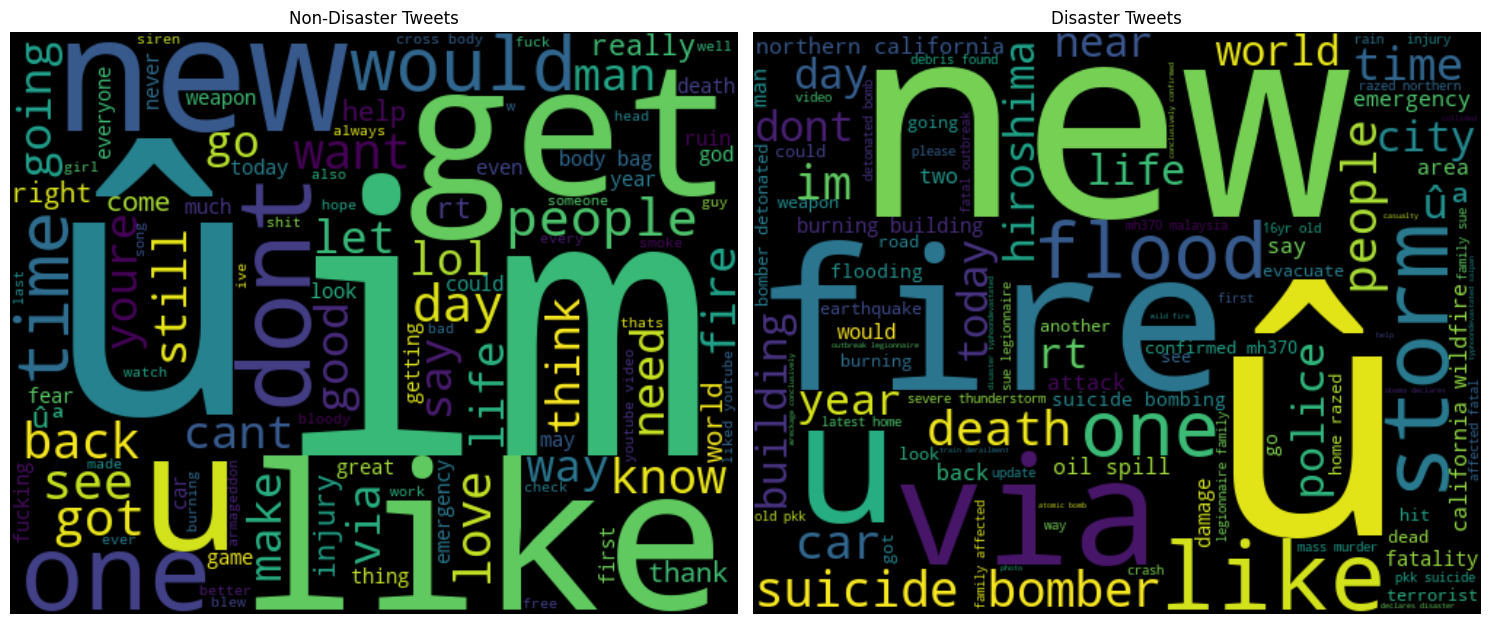

In [47]:
# Wordcloud of tweets of both vlasses
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

# Wordcloud for non-disaster tweets
wc_non_disaster = WordCloud(max_words=100, width=500, height=400, stopwords=stopwords.words('english')).generate(" ".join(train_df[train_df['target']==0].text_clean))
ax[0].imshow(wc_non_disaster, interpolation='bilinear')
ax[0].set_title('Non-Disaster Tweets')
ax[0].axis('off')

# Wordcloud for disaster tweets
wc_disaster = WordCloud(max_words=100, width=500, height=400, stopwords=stopwords.words('english')).generate(" ".join(train_df[train_df['target']==1].text_clean))
ax[1].imshow(wc_disaster, interpolation='bilinear')
ax[1].set_title('Disaster Tweets')
ax[1].axis('off')

plt.tight_layout()
plt.show()

### Modelling 

In [48]:
# Function for plotting confusion matrx
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
                xticklabels=['Not Disaster', 'Disaster'], 
                yticklabels=['Not Disaster', 'Disaster'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

In [49]:
# Splitting Data
X_train, X_val, y_train, y_val = train_test_split(
    train_df['text_clean'], 
    train_df['target'], 
    test_size=0.2, 
    random_state=42, 
    stratify=train_df['target']
)

## Base logistic regression

Classification Report for base logistic regression:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85       869
           1       0.85      0.70      0.76       654

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523



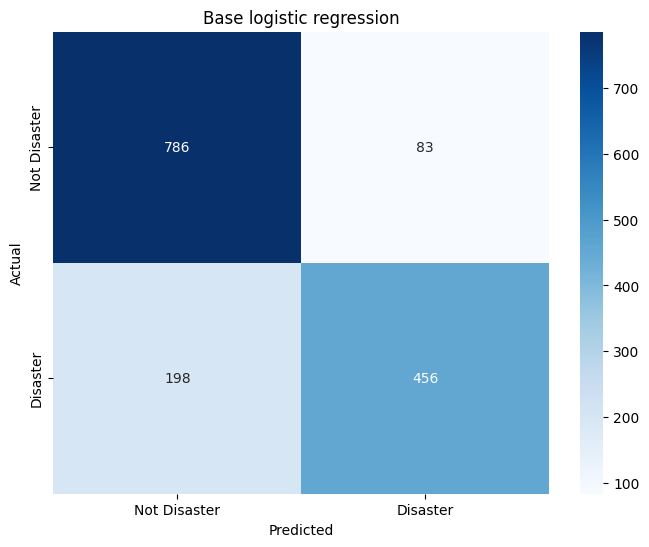

In [50]:
# Logistic Regression
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='liblinear')),
])

# Prediction
pipeline_lr.fit(X_train, y_train)
predictions_lr = pipeline_lr.predict(X_val)
probabilities_lr = pipeline_lr.predict_proba(X_val)[:, 1]

# Classificaiton report 
print("Classification Report for base logistic regression:\n", classification_report(y_val, predictions_lr))
# Confusion matrix
plot_confusion_matrix(y_val, predictions_lr, title ="Base logistic regression")


## Logisitic with Glove Embeddings

In [51]:
#  Glove embeddings from a file is loaded to return a dictionary of word to vector.
def load_glove_embeddings(filename):
    embeddings_dict = {}
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict

# Load the Glove embeddings into a dictionary
embedding_dict = load_glove_embeddings("glove.6B.100d.txt")


In [52]:
#   Getting average of Gloce vector representation for a given sentence
def get_vector_representation(sentence, embeddings_dict):
    words = sentence.split()
    sentence_matrix = np.array([embeddings_dict.get(word, np.zeros(100)) for word in words])
    
    # Average the embeddings
    avg_embedding = np.mean(sentence_matrix, axis=0)
    
    return avg_embedding

# training and validation data is converted to vector representation
X_train_vectors = np.array([get_vector_representation(sentence, embedding_dict) for sentence in X_train])
X_val_vectors = np.array([get_vector_representation(sentence, embedding_dict) for sentence in X_val])


Classification Report for log reg with glove:
               precision    recall  f1-score   support

           0       0.80      0.85      0.83       869
           1       0.78      0.73      0.75       654

    accuracy                           0.80      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.79      0.80      0.79      1523



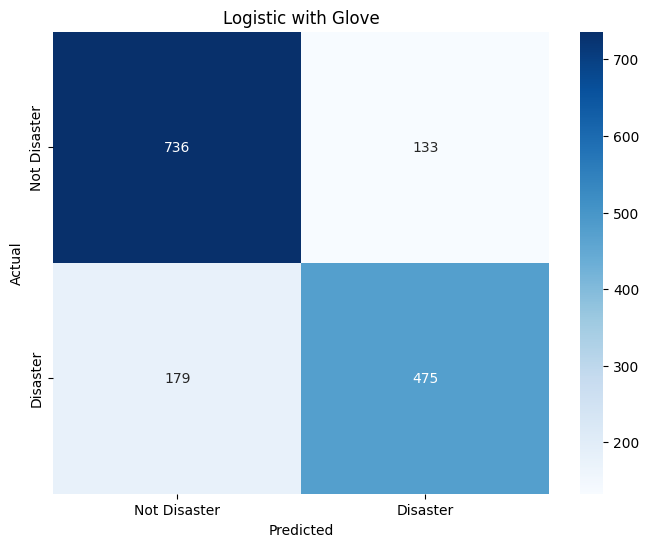

In [53]:
# Model inititalisaionl
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_vectors, y_train)

# Predict on the validation set
y_pred = log_reg.predict(X_val_vectors)

# Print classification metrics
print("Classification Report for log reg with glove:\n", classification_report(y_val, y_pred))

# Confusion matrix
plot_confusion_matrix(y_val, y_pred, title = "Logistic with Glove")


## Logisitic with hyperparameter search

In [54]:
# Hyperparameter grid for Logistic Regression
param_grid_lr = {
    'tfidf__max_df': [0.85, 0.9, 0.95],
    'tfidf__min_df': [2, 3, 4],
    'tfidf__max_features': [None, 5000, 10000],
    'clf__C': np.logspace(-4, 4, 20),
    'clf__penalty': ['l1', 'l2']
}
# RandomizedSearchCV for Logistic Regression
rs_lr = RandomizedSearchCV(pipeline_lr, param_distributions=param_grid_lr, n_iter=50, cv=5, verbose=True, n_jobs=-1)
rs_lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression: ", rs_lr.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Logistic Regression:  {'tfidf__min_df': 2, 'tfidf__max_features': 10000, 'tfidf__max_df': 0.9, 'clf__penalty': 'l2', 'clf__C': 0.615848211066026}


Classification Report ffor tuned log reg :
               precision    recall  f1-score   support

           0       0.80      0.92      0.86       869
           1       0.87      0.70      0.77       654

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.81      1523
weighted avg       0.83      0.82      0.82      1523



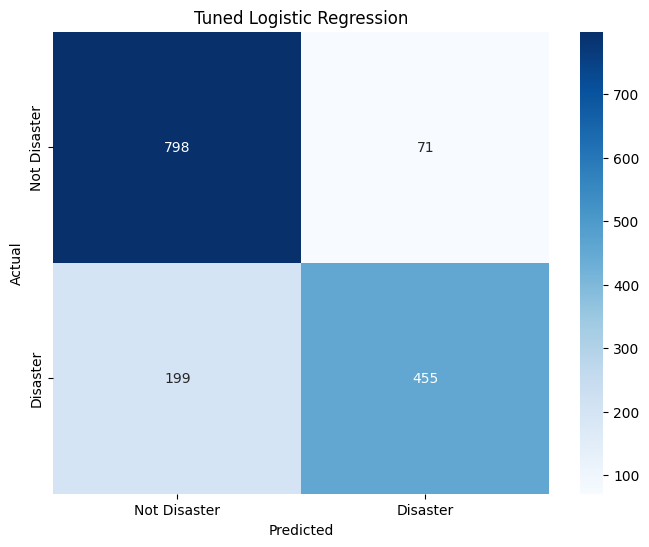

In [55]:
# Predict using the best model
predictions_tuned = rs_lr.predict(X_val)

# Metrics Calculation forlogistic tuned
print("Classification Report ffor tuned log reg :\n", classification_report(y_val, predictions_tuned))
plot_confusion_matrix(y_val, predictions_tuned, title = "Tuned Logistic Regression")

## Base Random Forest

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83       869
           1       0.80      0.70      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



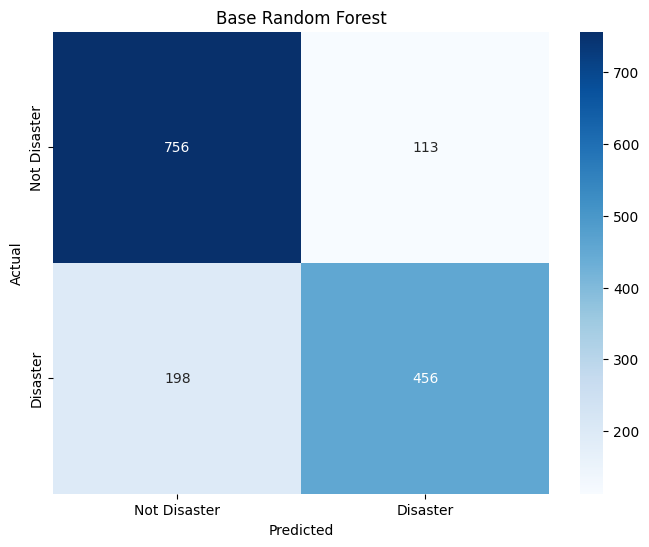

In [56]:
# Random Forest
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=42)),
])

# Fit and predict using Random Forest
pipeline_rf.fit(X_train, y_train)
predictions_rf = pipeline_rf.predict(X_val)
probabilities_rf = pipeline_rf.predict_proba(X_val)[:, 1]

# Metrics Calculation for Random Forest
metrics_rf = {
    'Precision': precision_score(y_val, predictions_rf),
    'Recall': recall_score(y_val, predictions_rf),
    'F1 Score': f1_score(y_val, predictions_rf),
    'ROC AUC': roc_auc_score(y_val, probabilities_rf)
}
print("Classification Report for Random Forest:\n", classification_report(y_val, predictions_rf))
plot_confusion_matrix(y_val, predictions_rf, title = "Base Random Forest")

## Random forest using hyperparameter tuning

In [57]:
# Hyperparameter grid for Random Forest
param_grid_rf = {
    'tfidf__max_df': [0.85, 0.9, 0.95],
    'tfidf__min_df': [2, 3, 4],
    'tfidf__max_features': [None, 5000, 10000],
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}
# RandomizedSearchCV for Random Forest
rs_rf = RandomizedSearchCV(pipeline_rf, param_distributions=param_grid_rf, n_iter=50, cv=5, verbose=True, n_jobs=-1)
rs_rf.fit(X_train, y_train)
print("Best parameters for Random Forest: ", rs_rf.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Random Forest:  {'tfidf__min_df': 3, 'tfidf__max_features': 5000, 'tfidf__max_df': 0.95, 'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 4, 'clf__max_depth': None}


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       869
           1       0.79      0.74      0.76       654

    accuracy                           0.80      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523



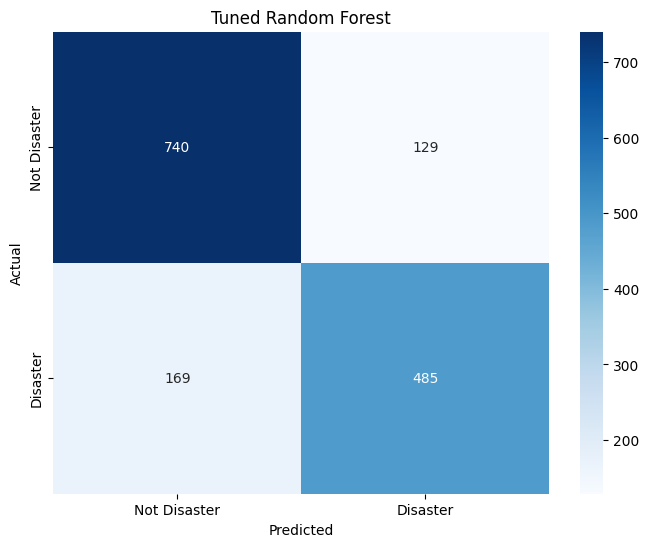

In [58]:
# Predict using the best model
rfpredictions_tuned = rs_rf.predict(X_val)

# Metrics Calculation forlogistic tuned
print("Classification Report:\n", classification_report(y_val, rfpredictions_tuned))
plot_confusion_matrix(y_val, rfpredictions_tuned, title = "Tuned Random Forest")

## Base LSTM

In [59]:
# Tokenizationand embedding matrix Generation:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text_clean'])
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_val_pad = pad_sequences(X_val_seq, maxlen=100)

In [60]:
# Initalsing LSTM Model:

base_model = Sequential()
base_model.add(Embedding(len(tokenizer.word_index)+1, 100, input_length=100))
base_model.add(LSTM(128, return_sequences=True, dropout=0.2))
base_model.add(LSTM(128))
base_model.add(Dense(1, activation='sigmoid'))
base_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
base_model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 100)          1664700   
                                                                 
 lstm_22 (LSTM)              (None, 100, 128)          117248    
                                                                 
 lstm_23 (LSTM)              (None, 128)               131584    
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1913661 (7.30 MB)
Trainable params: 1913661 (7.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


39/39 [==============================] - 1s 29ms/step


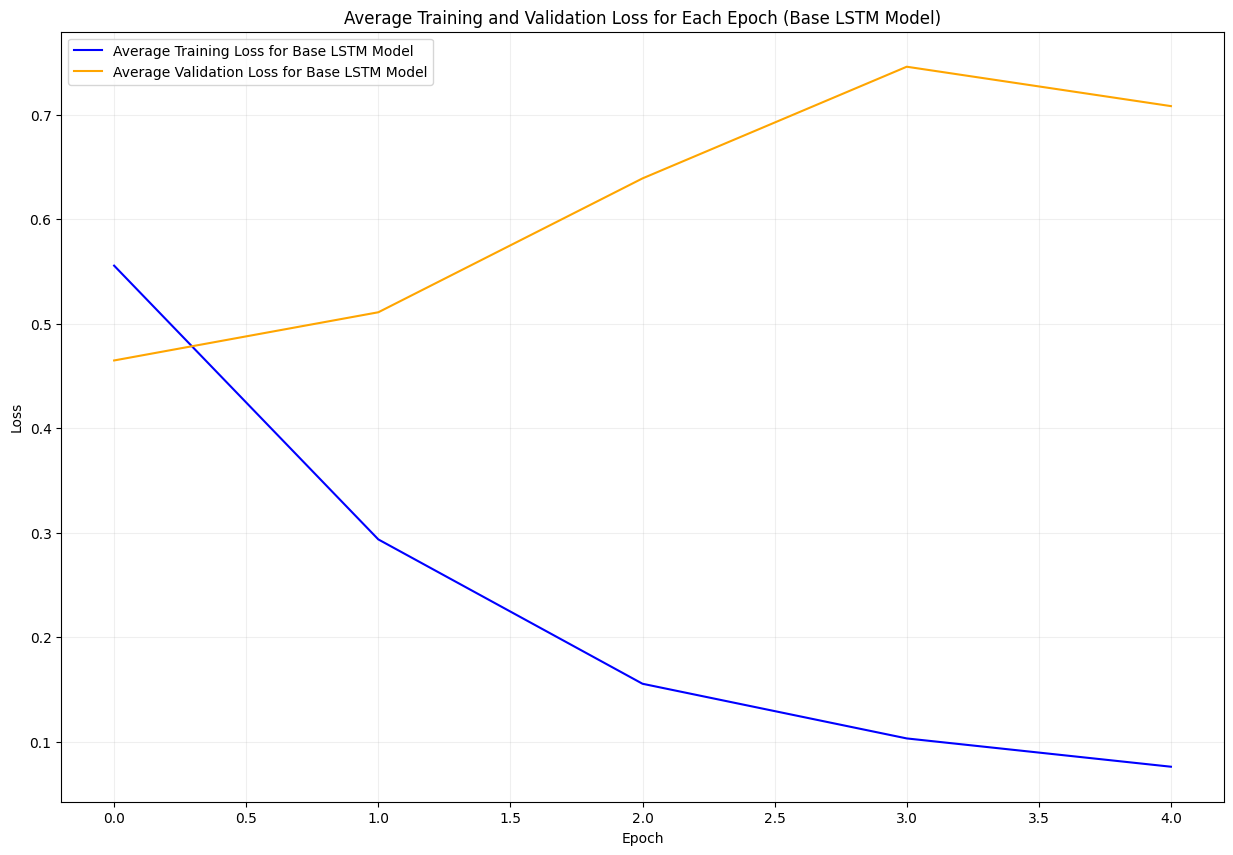

Classification Report for Base LSTM Model:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      3473
           1       0.72      0.72      0.72      2617

    accuracy                           0.76      6090
   macro avg       0.75      0.75      0.75      6090
weighted avg       0.76      0.76      0.76      6090



In [61]:
# 5-fold cross-validation for lstm using train set and then evaluating on test set(unseen data)
# Number of splits
n_splits = 5

# KFold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Placeholder for validation and training losses for each fold
val_losses_base = []
train_losses_base = []

# Placeholder for predictions and true values
all_y_pred = []
all_y_true = []

for idx, (train_index, val_index) in enumerate(kf.split(X_train_pad)):
    X_train_fold, X_val_fold = X_train_pad[train_index], X_train_pad[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Re-initializing the base LSTM model for each fold
    base_model = Sequential()
    base_model.add(Embedding(len(tokenizer.word_index)+1, 100, input_length=100))
    base_model.add(LSTM(128, return_sequences=True, dropout=0.2))
    base_model.add(LSTM(128))
    base_model.add(Dense(1, activation='sigmoid'))
    base_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Fitting the model
    history = base_model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=5, batch_size=32, verbose=0)
    
    # Appending validation and training loss for this fold
    val_losses_base.append(history.history['val_loss'])
    train_losses_base.append(history.history['loss'])
    
    # Predicting on the validation set
    y_pred_probs = base_model.predict(X_val_fold)
    y_pred_labels = [1 if prob > 0.5 else 0 for prob in y_pred_probs]
    
    # Gathering predictions and true values
    all_y_pred.extend(y_pred_labels)
    all_y_true.extend(y_val_fold.tolist())

# Calculating average validation and training loss across folds
avg_val_loss_base = np.mean(val_losses_base, axis=0)
avg_train_loss_base = np.mean(train_losses_base, axis=0)

# Plotting average validation and training loss
plt.figure(figsize=(15, 10))
plt.plot(avg_train_loss_base, label='Average Training Loss for Base LSTM Model', color='blue')
plt.plot(avg_val_loss_base, label='Average Validation Loss for Base LSTM Model', color='orange')
plt.title('Average Training and Validation Loss for Each Epoch (Base LSTM Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# Generating classification report
print("Classification Report for Base LSTM Model:")
print(classification_report(all_y_true, all_y_pred))


## LSTM with Glove

In [62]:
# GloVe embedding dictionary and matrix
# I have used the 100 dimensional glove embeddings here, which was downloaded from the official website.
embedding_dict = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embedding_dict[word] = vector

embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [63]:
# Number of splits
n_splits = 5

# KFold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store predictions and true labels
all_y_pred_glove = []
all_y_true_glove = []

# KFold loop for GloVe LSTM model
for train_index, val_index in kf.split(X_train_pad):
    X_train_fold, X_val_fold = X_train_pad[train_index], X_train_pad[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Re-initializing the GloVe LSTM model for each fold
    glove_model = Sequential()
    glove_model.add(Embedding(len(tokenizer.word_index)+1, 100, weights=[embedding_matrix], trainable=False, input_length=100))
    glove_model.add(LSTM(128, return_sequences=True, dropout=0.2))
    glove_model.add(LSTM(128))
    glove_model.add(Dense(1, activation='sigmoid'))
    glove_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Fitting the model
    glove_model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=5, batch_size=32, verbose=0)
    
    # Predicting on the validation fold and collecting true labels
    y_pred_probs = glove_model.predict(X_val_fold)
    y_pred_labels = [1 if prob > 0.5 else 0 for prob in y_pred_probs]
    
    all_y_pred_glove.extend(y_pred_labels)
    all_y_true_glove.extend(y_val_fold.tolist())

# Generating classification report for GloVe LSTM model
print("Classification Report for GloVe LSTM Model:")
print(classification_report(all_y_true_glove, all_y_pred_glove))


39/39 [==============================] - 2s 41ms/step
Classification Report for GloVe LSTM Model:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      3473
           1       0.82      0.70      0.76      2617

    accuracy                           0.81      6090
   macro avg       0.81      0.79      0.80      6090
weighted avg       0.81      0.81      0.80      6090



## BERT 

In [64]:
# Setting up the device for GPU usage
# mps is macbook's gpu and not meant for windows or linux architecture, 
device = torch.device("mps")
# device for windows gpu
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenizing data
encoded_data_train = tokenizer.batch_encode_plus(
    X_train, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_val, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [65]:
# Preparing the data for BERT
# extracting the 'input_ids' from the enocded training data for tokenized text
input_ids_train = encoded_data_train['input_ids']
# extracting the 'attention_mask' from the encoded training data to indicate which tkoens should be attended to and converting to tensor
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train.values)

# Previous steps done for validation data
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val.values)

# Creating a DataLoader 
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=32)
dataloader_val = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=32)


In [66]:
# Load BERT model with a classification head
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# Opitmizer & scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
# Lists to store losses and predictions
train_losses = []
val_losses = []
all_predictions = []
all_true_vals = []

# Training loop
for epoch in range(6):
    model.train()
    total_train_loss = 0
    for batch in dataloader_train:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        outputs = model(**inputs)
        loss = outputs[0]
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    avg_train_loss = total_train_loss / len(dataloader_train)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    total_val_loss = 0
    predictions, true_vals = [], []
    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        with torch.no_grad():        
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        total_val_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    avg_val_loss = total_val_loss / len(dataloader_val)
    val_losses.append(avg_val_loss)
    all_predictions.append(predictions)
    all_true_vals.append(true_vals)

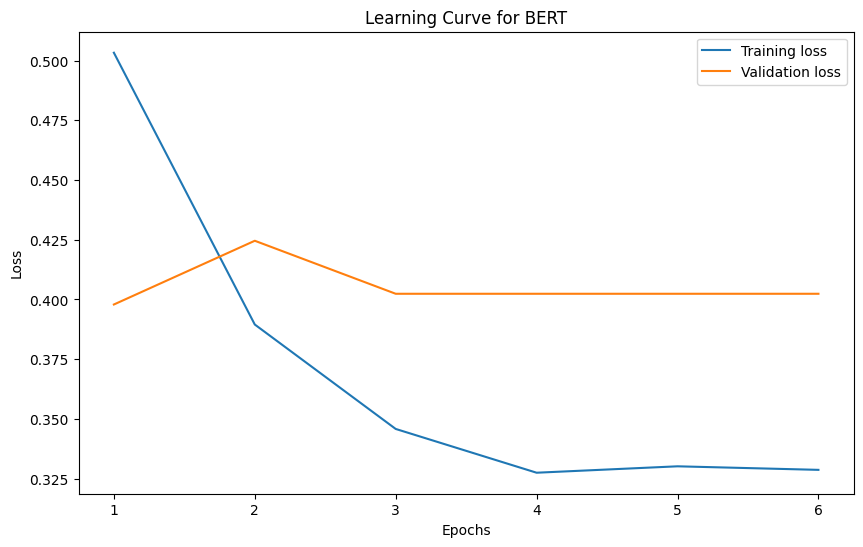

In [68]:
# Plotting the learning curve
plt.figure(figsize=(10, 6))
epochs = list(range(1, len(train_losses) + 1)) 
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.title('Learning Curve for BERT')
plt.xlabel('Epochs')
plt.xticks(epochs) 
plt.ylabel('Loss')
plt.legend()
plt.show()

Accuracy: 83.19%

Classification Report for BERT:
               precision    recall  f1-score   support

Not Disaster       0.85      0.86      0.85       869
    Disaster       0.81      0.80      0.80       654

    accuracy                           0.83      1523
   macro avg       0.83      0.83      0.83      1523
weighted avg       0.83      0.83      0.83      1523



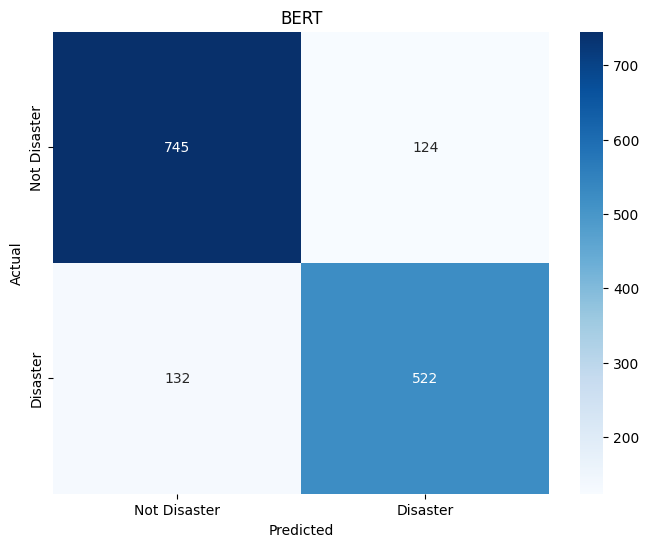

In [69]:
# Converting logits to predictions
final_predictions = []
for batch in predictions:
    for logit in batch:
        final_predictions.append(np.argmax(logit))

# Metrics calculation
accuracy = accuracy_score(y_val, final_predictions)
report = classification_report(y_val, final_predictions, target_names=['Not Disaster', 'Disaster'])

print(f"Accuracy: {accuracy*100:.2f}%")
print("\nClassification Report for BERT:\n", report)
plot_confusion_matrix(y_val, final_predictions, title = "BERT")


### Ensemble model: Using features from LSTM and BERT and running logisitic regression on it

In [70]:
# Extracting features from BERT
# CPU used here due to Mac's limitation on pytorch GPU support
device = torch.device("cpu")
model = model.to(device)


model_bert = BertModel.from_pretrained('bert-base-uncased')
model_bert.eval()
features_bert = []
# Iterating over batches
for batch in dataloader_val:
    batch = tuple(b.to(device) for b in batch)
    inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
    with torch.no_grad():
        outputs = model_bert(**inputs)
    # Using the last hidden state (i.e., embeddings) as features
    features = outputs[0][:,0,:].cpu().numpy()
    features_bert.extend(features)

features_bert = np.array(features_bert)

# Extracting features from LSTM
# Removing the final dense layer from LSTM model to get embeddings
base_model.pop()
base_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # Need to recompile after modifying
features_lstm = base_model.predict(X_val_pad)


# Concatenating features
ensemble_features = np.concatenate([features_bert, features_lstm], axis=1)

# Log reg model for ensemble
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(ensemble_features, y_val)

# Predictions from ensemble
ensemble_predictions = clf.predict(ensemble_features)


48/48 [==============================] - 2s 31ms/step


Classification Report for ensemble:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       869
           1       0.95      0.86      0.90       654

    accuracy                           0.92      1523
   macro avg       0.93      0.91      0.92      1523
weighted avg       0.92      0.92      0.92      1523



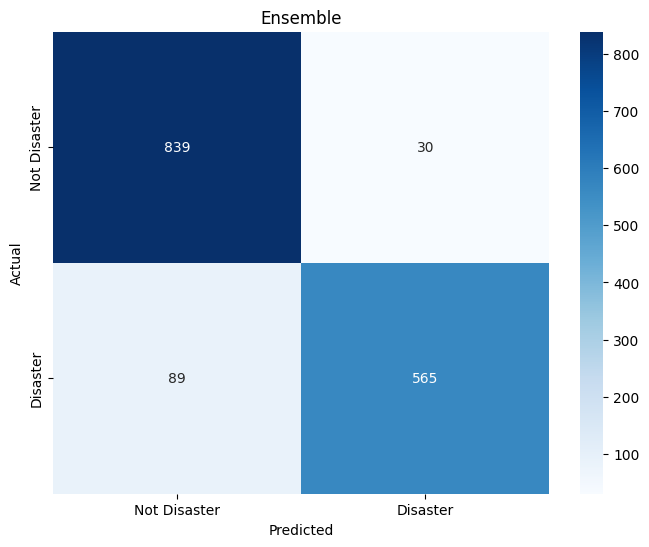

In [71]:
# metrics of ensemble model
print("Classification Report for ensemble:\n", classification_report(y_val, ensemble_predictions))
plot_confusion_matrix(y_val, ensemble_predictions, title = "Ensemble")
